In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

C:\Users\filip\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [2]:
tf.__version__

'2.0.0'

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [6]:
sys.path.append(os.getcwd())

In [7]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [8]:
full_experiment_data, encoders = prepare_experiment()

{'timestamp', 'item_id', 'split', 'user_id', 'rating'}
Dtype: DataType.TRAIN shape: 36532
Dtype: DataType.TEST shape: 21952
Dtype: DataType.VALID shape: 14697
N train ids: 10167
N train val ids: 10168


In [9]:
test_joined = full_experiment_data.Xraw_test.merge(full_experiment_data.Xhidden_test, on=['user_id', 'item_id'], how='inner')
test_joined.head(3)

,user_id,item_id,rating_x,rating_y
0,0,0,2.0,2.0
1,13,24,5.0,0.0
2,24,30,5.0,5.0


In [10]:
ytest = np.expand_dims(full_experiment_data.Xraw_test.rating.to_numpy(), axis=1)

In [11]:
crossvals, encoders = prepare_crossval_experiment(nsplits=10)

{'timestamp', 'item_id', 'split', 'user_id', 'rating'}


C:\Users\filip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processing cv 0
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 64083
Dtype: DataType.TEST shape: 5454
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65267
Dtype: DataType.TEST shape: 4732
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65928
Dtype: DataType.TEST shape: 4350
Dtype: DataType.VALID shape: 2903
N train ids: 18301
N train val ids: 2034
Processing cv 3
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65835
Dtype: DataType.TEST shape: 4353
Dtype: DataType.VALID shape: 2993
N train ids: 18301
N train val ids: 2034
Processing cv 4
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 66018
Dtype: DataType.TEST shape: 4293
Dtype: DataType.VALID shape: 2870
N train ids: 18301
N 

In [12]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [13]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [14]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [17]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train[:, 0].astype('int32'),
        exd.Xfeatures_train[:, 1].astype('int32'),
        exd.Xfeatures_train[:, 2].astype('int32'),
        exd.Xfeatures_train[:, 3].astype('int32'),
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid[:, 0].astype('int32'),
        exd.Xfeatures_valid[:, 1].astype('int32'),
        exd.Xfeatures_valid[:, 2].astype('int32'),
        exd.Xfeatures_valid[:, 3].astype('int32'),
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    # TODO: investigat emissing enties in matrices below - why there are so many nan's
    x_test_reconstruction = [
        exd.Xhidden_test.user_id.to_numpy(dtype='int32'),
        exd.Xhidden_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test[:, 0].astype('int32'),
        exd.Xfeatures_test[:, 1].astype('int32'),
        exd.Xfeatures_test[:, 2].astype('int32'),
        exd.Xfeatures_test[:, 3].astype('int32'),
    ]
    y_test_reconstruction = exd.Xhidden_test.rating
    
    x_test_pred = [
        exd.test_records_selected.user_id.to_numpy(dtype='int32'),
        exd.test_records_selected.item_id.to_numpy(dtype='int32'),
        exd.test_records_selected.iloc[:, :-5].to_numpy(dtype='int32')
    ]
    
    return x, y, x_val, y_val, x_test_reconstruction

In [17]:
exd = crossvals[0]

In [18]:
nulls = []
for exd in crossvals:
    null_i = exd.test_records_selected.iloc[:, :-5].isna().sum(axis=0).any()
    nulls.append(null_i)
nulls

[False, False, False, False, False, False, False, False, False, False]

In [18]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [20]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer=optimizer, metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [32]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 12s 188us/sample - loss: 2.7959 - mse_masked: 2.7955 - mae: 1.2756 - mape_masked: 0.4327 - val_loss: 1.4413 - val_mse_masked: 1.4418 - val_mae: 0.9269 - val_mape_masked: 0.4105
Epoch 2/15
64083/64083 [==============================] - 11s 168us/sample - loss: 1.2329 - mse_masked: 1.2329 - mae: 0.8386 - mape_masked: 0.3572 - val_loss: 1.4097 - val_mse_masked: 1.4103 - val_mae: 0.9224 - val_mape_masked: 0.4026
Epoch 3/15
64083/64083 [==============================] - 11s 167us/sample - loss: 0.9690 - mse_masked: 0.9692 - mae: 0.7316 - mape_masked: 0.3036 - val_loss: 1.4089 - val_mse_masked: 1.4094 - val_mae: 0.9365 - val_mape_masked: 0.3997
Epoch 4/15
64083/64083 [==============================] - 11s 168us/sample - loss: 0.8195 - mse_masked: 0.8195 - mae: 0.6736 - mape_masked: 0.2702 - val_loss: 1.4224 - val_mse_masked: 1.4229 - val_mae: 0.9369 - val_mape_masked: 0.4016
Epoch 5/15


In [33]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

In [36]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)

In [37]:
colab_res

,colab_mse,colab_mape
0,1.341046,0.381724
1,1.451853,0.417127
2,1.405102,0.398994
3,1.407544,0.395755
4,1.268155,0.358347
5,1.203991,0.343120
6,1.395020,0.387410
7,1.440887,0.404051
8,1.447349,0.405730
9,1.412892,0.401230


## Deep recommender

In [20]:
exd = crossvals[0]

In [21]:
exd.Xfeatures_train.shape

(64083, 5)

In [22]:
for k, e in encoders.items():
    print(f"{k}: {e.classes_.shape[0]}")

user_attr: 3
model_attr: 3
brand: 51
category: 10
year: 20


In [115]:
def autorec_multiple_embeddings(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    
    dim_embed = 36
    dim_embed_userattr = 3
    dim_embed_modelattr = 3
    dim_embed_brand = 8
    dim_embed_category = 4
    dim_embed_year = 4
    
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())
    
    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))
    
    uattr_input = krs.Input(shape=(1, ), name='userattr_input', dtype='int32')
    uattr = krs.layers.Embedding(4, dim_embed_userattr, embeddings_initializer='he_normal',)(uattr_input)
    uattr = krs.layers.Flatten()(uattr)
    
    mattr_input = krs.Input(shape=(1, ), name='modelattr_input', dtype='int32')
    mattr = krs.layers.Embedding(4, dim_embed_modelattr, embeddings_initializer='he_normal',)(mattr_input)
    mattr = krs.layers.Flatten()(mattr)
    
    gender_emb = krs.layers.Embedding(4, 3, embeddings_initializer='he_normal',)
    uattr_emb = gender_emb(uattr_input)
    uattr_emb = krs.layers.Flatten()(uattr_emb)
    
    mattr_emb = gender_emb(mattr_input)
    mattr_emb = krs.layers.Flatten()(mattr_emb)
                                      
    brand_input = krs.Input(shape=(1, ), name='brand_input', dtype='int32')
    br = krs.layers.Embedding(52, dim_embed_brand, embeddings_initializer='he_normal',)(brand_input)
    br = krs.layers.Flatten()(br)
    
    cat_input = krs.Input(shape=(1, ), name='cat_input', dtype='int32')
    cat =  krs.layers.Embedding(11, dim_embed_category, embeddings_initializer='he_normal',)(cat_input)
    cat = krs.layers.Flatten()(cat)
    
    all_features = krs.layers.Concatenate(axis=1)([u, u_bias, i, i_bias, uattr_emb, mattr_emb, br, cat])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(32, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='sigmoid')(d2)
    out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, uattr_input, mattr_input, brand_input, cat_input], outputs=out, *args, **kwargs)

    model.compile(loss=mse_masked, optimizer=optimizer, metrics=metrics)
    print(model.summary())
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [92]:
preselect_exd = crossvals[0]

In [93]:
krs.backend.clear_session()

In [94]:
import gc
gc.collect()

60

In [71]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [lr_schedule]})

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

66618/66618 [==============================] - 11s 168us/sample - loss: 1.3773 - mse_masked: 1.3428 - mape_masked: 0.3818 - mae: 0.8939 - val_loss: 1.3808 - val_mse_masked: 1.3469 - val_mape_masked: 0.3733 - val_mae: 0.9310
Epoch 7/15
66618/66618 [==============================] - 12s 173us/sample - loss: 1.3441 - mse_masked: 1.3110 - mape_masked: 0.3751 - mae: 0.8809 - val_loss: 1.3485 - val_mse_masked: 1.3156 - val_mape_masked: 0.3734 - val_mae: 0.8787
Epoch 8/15
66618/66618 [==============================] - 11s 168us/sample - loss: 1.2977 - mse_masked: 1.2656 - mape_masked: 0.3652 - mae: 0.8610 - val_loss: 1.4007 - val_mse_masked: 1.3688 - val_mape_masked: 0.3716 - val_mae: 0.9468
Epoch 9/15
66618/66618 [==============================] - 11s 166us/sample - loss: 1.1465 - mse_masked: 1.1134 - mape_masked: 0.3305 - mae: 0.7903 - val_loss: 1.3852 - val_mse_masked: 1.3510 - val_mape_masked: 0.3723 - val_mae: 0.8880
Epoch 10/15
66618/66618 [==============================] - 11s 162us/sa

In [72]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

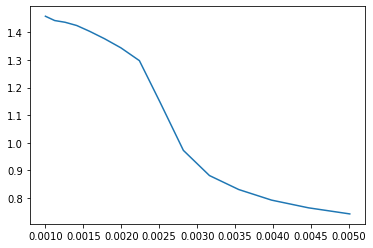

In [73]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

In [111]:
lr = 0.005

### Deep autorec crossval

In [116]:
import gc
tf.keras.backend.clear_session()
gc.collect()

autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.002, patience=3)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': mse_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
    
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

Epoch 7/15
64083/64083 [==============================] - 12s 193us/sample - loss: 0.9093 - mse_masked: 0.8796 - mape_masked: 0.2723 - mae: 0.6669 - val_loss: 1.4966 - val_mse_masked: 1.4671 - val_mape_masked: 0.4089 - val_mae: 0.9075
MSE: [1.3970305]
Mape: [0.3856218]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
____________________

65267/65267 [==============================] - 13s 202us/sample - loss: 1.1743 - mse_masked: 1.1460 - mape_masked: 0.3369 - mae: 0.8041 - val_loss: 1.4706 - val_mse_masked: 1.4405 - val_mape_masked: 0.4048 - val_mae: 0.9406
Epoch 6/15
65267/65267 [==============================] - 12s 191us/sample - loss: 0.9510 - mse_masked: 0.9192 - mape_masked: 0.2819 - mae: 0.6898 - val_loss: 1.5435 - val_mse_masked: 1.5120 - val_mape_masked: 0.4205 - val_mae: 0.8996
Epoch 7/15
65267/65267 [==============================] - 13s 205us/sample - loss: 0.8506 - mse_masked: 0.8187 - mape_masked: 0.2557 - mae: 0.6338 - val_loss: 1.5293 - val_mse_masked: 1.4989 - val_mape_masked: 0.4176 - val_mae: 0.9006
Epoch 8/15
65267/65267 [==============================] - 13s 201us/sample - loss: 0.7973 - mse_masked: 0.7665 - mape_masked: 0.2421 - mae: 0.6068 - val_loss: 1.5029 - val_mse_masked: 1.4739 - val_mape_masked: 0.4126 - val_mae: 0.9116
MSE: [1.3970305, 1.4807631]
Mape: [0.3856218, 0.41081047]
Model: "model

65928/65928 [==============================] - 13s 198us/sample - loss: 1.4053 - mse_masked: 1.3716 - mape_masked: 0.3886 - mae: 0.9079 - val_loss: 1.4188 - val_mse_masked: 1.3890 - val_mape_masked: 0.3947 - val_mae: 0.8698
Epoch 3/15
65928/65928 [==============================] - 13s 205us/sample - loss: 1.3573 - mse_masked: 1.3276 - mape_masked: 0.3786 - mae: 0.8860 - val_loss: 1.4032 - val_mse_masked: 1.3774 - val_mape_masked: 0.3905 - val_mae: 0.8648
Epoch 4/15
65928/65928 [==============================] - 13s 199us/sample - loss: 1.2771 - mse_masked: 1.2500 - mape_masked: 0.3618 - mae: 0.8524 - val_loss: 1.4260 - val_mse_masked: 1.3992 - val_mape_masked: 0.3894 - val_mae: 0.8563
Epoch 5/15
65928/65928 [==============================] - 13s 194us/sample - loss: 1.0771 - mse_masked: 1.0460 - mape_masked: 0.3125 - mae: 0.7508 - val_loss: 1.4363 - val_mse_masked: 1.4058 - val_mape_masked: 0.3927 - val_mae: 0.8546
Epoch 6/15
65928/65928 [==============================] - 13s 203us/sam

65835/65835 [==============================] - 15s 234us/sample - loss: 1.4524 - mse_masked: 1.4123 - mape_masked: 0.3979 - mae: 0.9309 - val_loss: 1.2893 - val_mse_masked: 1.2507 - val_mape_masked: 0.3494 - val_mae: 0.8902
Epoch 2/15
65835/65835 [==============================] - 14s 205us/sample - loss: 1.4282 - mse_masked: 1.3960 - mape_masked: 0.3944 - mae: 0.9208 - val_loss: 1.2638 - val_mse_masked: 1.2311 - val_mape_masked: 0.3474 - val_mae: 0.8729
Epoch 3/15
65835/65835 [==============================] - 14s 209us/sample - loss: 1.3971 - mse_masked: 1.3699 - mape_masked: 0.3878 - mae: 0.9035 - val_loss: 1.2462 - val_mse_masked: 1.2173 - val_mape_masked: 0.3438 - val_mae: 0.8421
Epoch 4/15
65835/65835 [==============================] - 13s 201us/sample - loss: 1.3564 - mse_masked: 1.3325 - mape_masked: 0.3795 - mae: 0.8845 - val_loss: 1.2362 - val_mse_masked: 1.2089 - val_mape_masked: 0.3406 - val_mae: 0.8242
Epoch 5/15
65835/65835 [==============================] - 13s 202us/sam

66018/66018 [==============================] - 17s 256us/sample - loss: 1.4598 - mse_masked: 1.4199 - mape_masked: 0.3999 - mae: 0.9362 - val_loss: 1.4230 - val_mse_masked: 1.3909 - val_mape_masked: 0.3904 - val_mae: 0.9350
Epoch 2/15
66018/66018 [==============================] - 14s 206us/sample - loss: 1.4421 - mse_masked: 1.4108 - mape_masked: 0.3983 - mae: 0.9305 - val_loss: 1.4018 - val_mse_masked: 1.3771 - val_mape_masked: 0.3895 - val_mae: 0.9197
Epoch 3/15
66018/66018 [==============================] - 13s 199us/sample - loss: 1.4224 - mse_masked: 1.3974 - mape_masked: 0.3950 - mae: 0.9222 - val_loss: 1.3745 - val_mse_masked: 1.3538 - val_mape_masked: 0.3814 - val_mae: 0.9073
Epoch 4/15
66018/66018 [==============================] - 13s 203us/sample - loss: 1.3866 - mse_masked: 1.3644 - mape_masked: 0.3869 - mae: 0.9020 - val_loss: 1.3344 - val_mse_masked: 1.3171 - val_mape_masked: 0.3749 - val_mae: 0.8713
Epoch 5/15
66018/66018 [==============================] - 14s 206us/sam

66100/66100 [==============================] - 16s 247us/sample - loss: 1.4656 - mse_masked: 1.4240 - mape_masked: 0.4007 - mae: 0.9359 - val_loss: 1.2991 - val_mse_masked: 1.2638 - val_mape_masked: 0.3589 - val_mae: 0.8998
Epoch 2/15
66100/66100 [==============================] - 14s 216us/sample - loss: 1.4415 - mse_masked: 1.4079 - mape_masked: 0.3978 - mae: 0.9279 - val_loss: 1.2659 - val_mse_masked: 1.2368 - val_mape_masked: 0.3509 - val_mae: 0.8918
Epoch 3/15
66100/66100 [==============================] - 13s 204us/sample - loss: 1.4037 - mse_masked: 1.3748 - mape_masked: 0.3900 - mae: 0.9100 - val_loss: 1.2325 - val_mse_masked: 1.2072 - val_mape_masked: 0.3449 - val_mae: 0.8608
Epoch 4/15
66100/66100 [==============================] - 13s 204us/sample - loss: 1.3547 - mse_masked: 1.3289 - mape_masked: 0.3807 - mae: 0.8915 - val_loss: 1.2308 - val_mse_masked: 1.2069 - val_mape_masked: 0.3383 - val_mae: 0.8574
Epoch 5/15
66100/66100 [==============================] - 14s 211us/sam

66100/66100 [==============================] - 16s 249us/sample - loss: 1.4533 - mse_masked: 1.4109 - mape_masked: 0.3976 - mae: 0.9292 - val_loss: 1.3474 - val_mse_masked: 1.3068 - val_mape_masked: 0.3560 - val_mae: 0.9347
Epoch 2/15
66100/66100 [==============================] - 14s 216us/sample - loss: 1.4138 - mse_masked: 1.3788 - mape_masked: 0.3903 - mae: 0.9097 - val_loss: 1.2786 - val_mse_masked: 1.2443 - val_mape_masked: 0.3535 - val_mae: 0.8477
Epoch 3/15
66100/66100 [==============================] - 14s 206us/sample - loss: 1.3691 - mse_masked: 1.3391 - mape_masked: 0.3813 - mae: 0.8897 - val_loss: 1.2690 - val_mse_masked: 1.2394 - val_mape_masked: 0.3513 - val_mae: 0.8488
Epoch 4/15
66100/66100 [==============================] - 14s 207us/sample - loss: 1.3214 - mse_masked: 1.2951 - mape_masked: 0.3726 - mae: 0.8739 - val_loss: 1.2771 - val_mse_masked: 1.2492 - val_mape_masked: 0.3476 - val_mae: 0.8744
Epoch 5/15
66100/66100 [==============================] - 14s 206us/sam

66272/66272 [==============================] - 16s 241us/sample - loss: 1.4378 - mse_masked: 1.3963 - mape_masked: 0.3939 - mae: 0.9233 - val_loss: 1.5827 - val_mse_masked: 1.5395 - val_mape_masked: 0.4290 - val_mae: 1.0163
Epoch 2/15
66272/66272 [==============================] - 14s 211us/sample - loss: 1.3987 - mse_masked: 1.3645 - mape_masked: 0.3866 - mae: 0.9043 - val_loss: 1.5339 - val_mse_masked: 1.4964 - val_mape_masked: 0.4259 - val_mae: 0.9648
Epoch 3/15
66272/66272 [==============================] - 13s 203us/sample - loss: 1.3510 - mse_masked: 1.3215 - mape_masked: 0.3769 - mae: 0.8833 - val_loss: 1.5698 - val_mse_masked: 1.5369 - val_mape_masked: 0.4317 - val_mae: 0.9135
Epoch 4/15
66272/66272 [==============================] - 14s 205us/sample - loss: 1.2964 - mse_masked: 1.2696 - mape_masked: 0.3663 - mae: 0.8622 - val_loss: 1.5477 - val_mse_masked: 1.5155 - val_mape_masked: 0.4217 - val_mae: 0.9478
Epoch 5/15
66272/66272 [==============================] - 13s 196us/sam

66408/66408 [==============================] - 16s 248us/sample - loss: 1.4448 - mse_masked: 1.4044 - mape_masked: 0.3956 - mae: 0.9273 - val_loss: 1.4641 - val_mse_masked: 1.4290 - val_mape_masked: 0.4054 - val_mae: 0.9439
Epoch 2/15
66408/66408 [==============================] - 14s 209us/sample - loss: 1.4193 - mse_masked: 1.3868 - mape_masked: 0.3919 - mae: 0.9169 - val_loss: 1.4458 - val_mse_masked: 1.4172 - val_mape_masked: 0.3995 - val_mae: 0.9530
Epoch 3/15
66408/66408 [==============================] - 14s 208us/sample - loss: 1.3797 - mse_masked: 1.3518 - mape_masked: 0.3835 - mae: 0.8972 - val_loss: 1.4208 - val_mse_masked: 1.3963 - val_mape_masked: 0.3994 - val_mae: 0.8926
Epoch 4/15
66408/66408 [==============================] - 14s 208us/sample - loss: 1.3327 - mse_masked: 1.3082 - mape_masked: 0.3744 - mae: 0.8778 - val_loss: 1.4141 - val_mse_masked: 1.3913 - val_mape_masked: 0.3934 - val_mae: 0.9335
Epoch 5/15
66408/66408 [==============================] - 14s 210us/sam

66618/66618 [==============================] - 17s 260us/sample - loss: 1.4496 - mse_masked: 1.4074 - mape_masked: 0.3960 - mae: 0.9288 - val_loss: 1.3950 - val_mse_masked: 1.3568 - val_mape_masked: 0.3797 - val_mae: 0.9413
Epoch 2/15
66618/66618 [==============================] - 14s 209us/sample - loss: 1.4220 - mse_masked: 1.3879 - mape_masked: 0.3917 - mae: 0.9164 - val_loss: 1.3412 - val_mse_masked: 1.3094 - val_mape_masked: 0.3748 - val_mae: 0.8739
Epoch 3/15
66618/66618 [==============================] - 14s 214us/sample - loss: 1.3829 - mse_masked: 1.3540 - mape_masked: 0.3835 - mae: 0.8949 - val_loss: 1.3479 - val_mse_masked: 1.3208 - val_mape_masked: 0.3723 - val_mae: 0.9140
Epoch 4/15
66618/66618 [==============================] - 14s 215us/sample - loss: 1.3359 - mse_masked: 1.3106 - mape_masked: 0.3744 - mae: 0.8766 - val_loss: 1.3643 - val_mse_masked: 1.3394 - val_mape_masked: 0.3726 - val_mae: 0.9291
Epoch 5/15
66618/66618 [==============================] - 14s 217us/sam

In [117]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [90]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

In [63]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [118]:
autorec_results[["autorec_mape", "autorec_mse"]]

,autorec_mape,autorec_mse
0,0.385622,1.397030
1,0.410810,1.480763
2,0.390489,1.509166
3,0.383728,1.491422
4,0.344507,1.305385
5,0.327501,1.253417
6,0.383630,1.384025
7,0.398820,1.497464
8,0.398155,1.496416
9,0.392516,1.441800


In [119]:
colab_res[["colab_mape", "colab_mse"]]

,colab_mape,colab_mse
0,0.381724,1.341046
1,0.417127,1.451853
2,0.398994,1.405102
3,0.395755,1.407544
4,0.358347,1.268155
5,0.343120,1.203991
6,0.387410,1.395020
7,0.404051,1.440887
8,0.405730,1.447349
9,0.401230,1.412892


In [121]:
autorec_results.autorec_mse.mean(), colab_res.colab_mse.mean()

(1.4256889343261718, 1.3773839950561524)

In [122]:
autorec_results.autorec_mape.mean(), colab_res.colab_mape.mean()

(0.38157770335674285, 0.3893488645553589)

# Compare two models

In [123]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative='two-sided')

WilcoxonResult(statistic=2.0, pvalue=0.010826921277131306)

In [124]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=1.0, pvalue=0.008045237486561687)

In [125]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse, use_continuity=True)

MannwhitneyuResult(statistic=32.0, pvalue=0.09293836618293788)

In [127]:
st.mannwhitneyu(autorec_results.autorec_mape, colab_res.colab_mape, use_continuity=True)

MannwhitneyuResult(statistic=37.0, pvalue=0.1723521110034788)

In [45]:
st.kruskal(autorec_results.autorec_mape, colab_res.autorec_mape)

AttributeError: 'DataFrame' object has no attribute 'autorec_mape'

In [87]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=6.504160376112249, pvalue=8.209933725459241e-06)

In [88]:
st.ttest_ind(autorec_results.autorec_mape, colab_res.colab_mape, equal_var=False)

Ttest_indResult(statistic=-0.6909034172275881, pvalue=0.49870164935874917)